In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score, v_measure_score

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

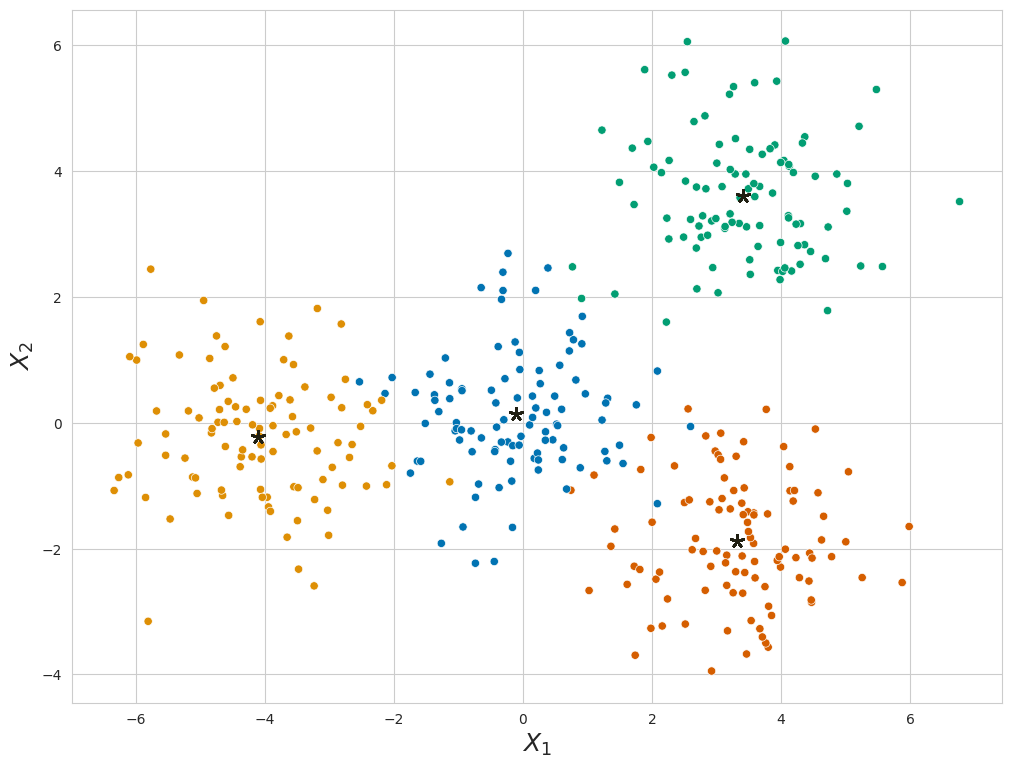

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [5]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.array(dists).T
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """

        
        cluster_labels = []
        n_samples, n_features = X.shape
        for sample in range(n_samples):
            dists2 = np.sum(np.square(X[sample, :] - self.centroids), axis=1)**(1/2)
            cluster_labels.append(dists2)
        cluster_labels = np.argmin(np.array(cluster_labels), axis=1)
        
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = None
        dist = (np.sum(np.square(centroid - X), axis=1)**(1/2))
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

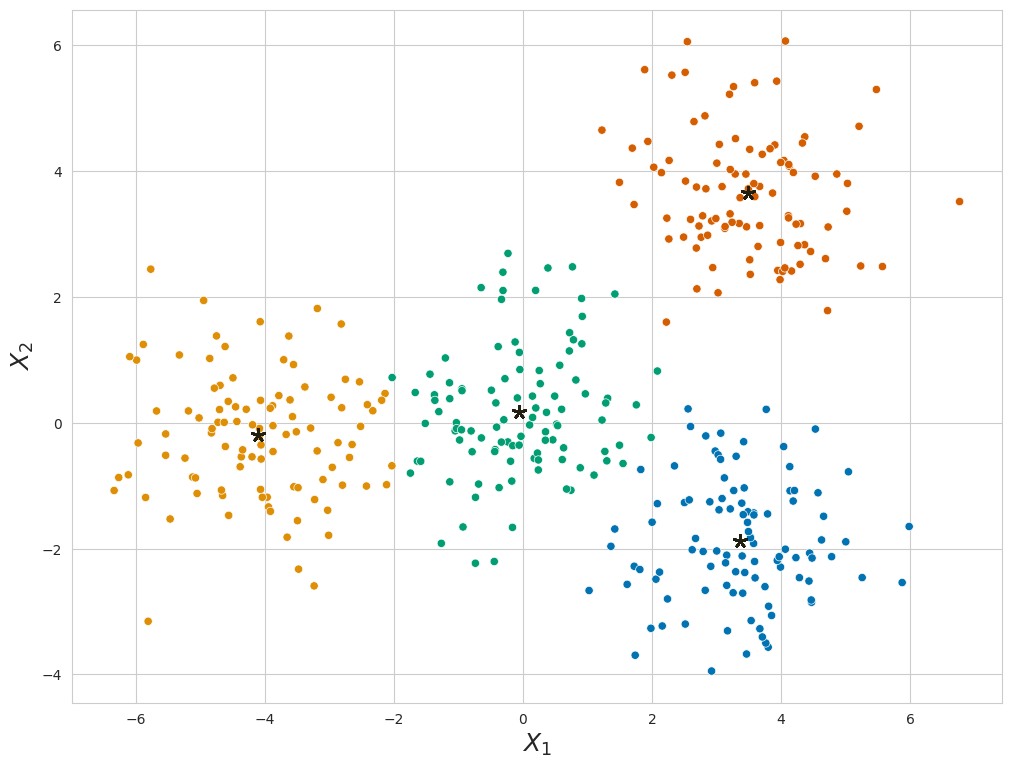

array([3, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 1, 2, 1, 2, 1, 3, 3, 2, 2,
       3, 1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2, 0, 0, 2, 3, 0, 0, 0, 2, 0, 2,
       3, 1, 2, 0, 3, 1, 3, 3, 1, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 2, 2, 0,
       1, 0, 0, 3, 0, 3, 2, 1, 3, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 3, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 1, 0, 0, 2, 2, 2, 0, 2, 1, 2,
       3, 3, 1, 3, 1, 0, 3, 1, 3, 1, 0, 2, 0, 0, 1, 3, 2, 0, 1, 1, 3, 0,
       0, 2, 1, 3, 2, 3, 2, 0, 0, 1, 3, 0, 0, 3, 3, 0, 1, 1, 3, 2, 2, 0,
       2, 0, 2, 1, 3, 3, 0, 0, 2, 3, 1, 3, 2, 2, 0, 2, 3, 1, 3, 1, 1, 0,
       3, 3, 0, 1, 1, 0, 3, 1, 3, 1, 1, 1, 3, 0, 3, 1, 2, 1, 2, 0, 2, 3,
       0, 3, 1, 1, 2, 1, 2, 0, 1, 1, 2, 3, 3, 3, 0, 1, 3, 3, 1, 3, 2, 0,
       1, 2, 3, 2, 3, 3, 0, 2, 2, 2, 1, 2, 0, 1, 1, 3, 0, 0, 1, 3, 2, 0,
       2, 0, 1, 2, 1, 3, 0, 3, 3, 0, 3, 3, 0, 2, 3, 0, 2, 2, 3, 2, 1, 3,
       2, 0, 3, 1, 3, 2, 3, 3, 2, 3, 3, 1, 2, 0, 2, 1, 3, 1, 1, 3, 2, 1,
       2, 1, 1, 3, 0, 0, 1, 0, 3, 2, 3, 1, 2, 3, 0,

In [8]:
km = MyKMeans(n_clusters=4, max_iter=5, visualize=True)
km.fit(X)
km.predict(X)

На 5 итерациях при 4 кластерах и рандомном выборе центроидов (как хорошо заранее знать k!) сходимость прекрасная.

Отличия от оригинального изображения заключаются в несовпадении некоторых точек (которые не вполне соответствуют дистанциям до кластеров) и порядком цветов.

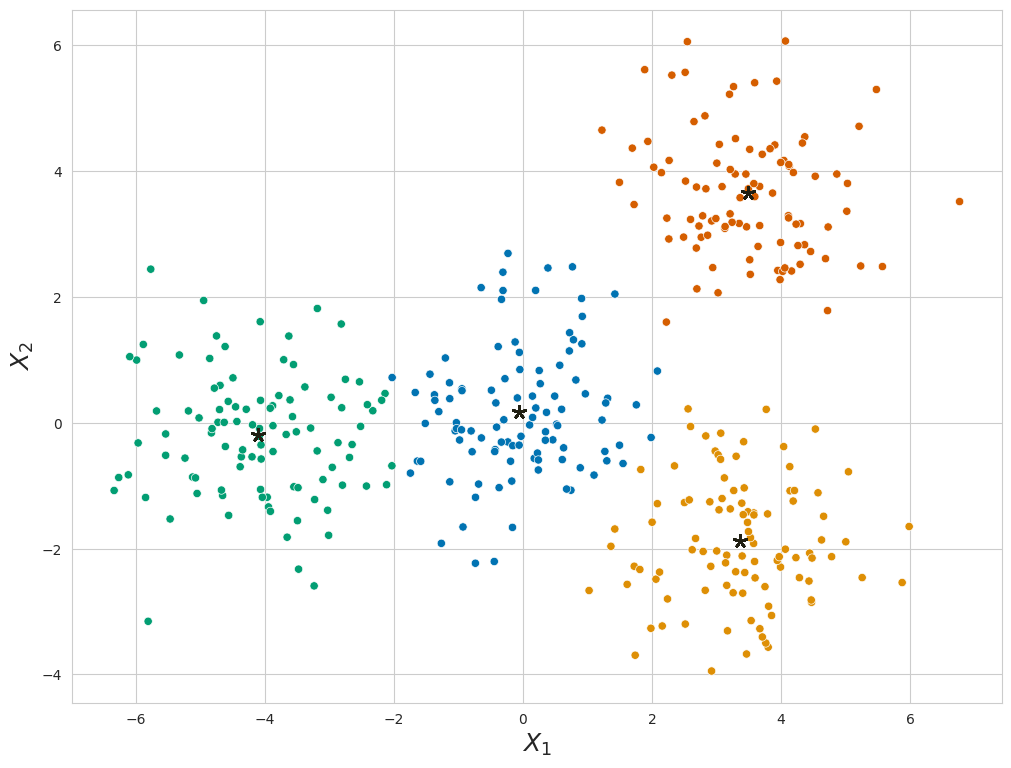

array([3, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 3, 3, 0, 0,
       3, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 1, 1, 0, 3, 1, 1, 1, 0, 1, 0,
       3, 2, 0, 1, 3, 2, 3, 3, 2, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1,
       2, 1, 1, 3, 1, 3, 0, 2, 3, 1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 3, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0,
       3, 3, 2, 3, 2, 1, 3, 2, 3, 2, 1, 0, 1, 1, 2, 3, 0, 1, 2, 2, 3, 1,
       1, 0, 2, 3, 0, 3, 0, 1, 1, 2, 3, 1, 1, 3, 3, 1, 2, 2, 3, 0, 0, 1,
       0, 1, 0, 2, 3, 3, 1, 1, 0, 3, 2, 3, 0, 0, 1, 0, 3, 2, 3, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 2, 3, 2, 2, 2, 3, 1, 3, 2, 0, 2, 0, 1, 0, 3,
       1, 3, 2, 2, 0, 2, 0, 1, 2, 2, 0, 3, 3, 3, 1, 2, 3, 3, 2, 3, 0, 1,
       2, 0, 3, 0, 3, 3, 1, 0, 0, 0, 2, 0, 1, 2, 2, 3, 1, 1, 2, 3, 0, 1,
       0, 1, 2, 0, 2, 3, 1, 3, 3, 1, 3, 3, 1, 0, 3, 1, 0, 0, 3, 0, 2, 3,
       0, 1, 3, 2, 3, 0, 3, 3, 0, 3, 3, 2, 0, 1, 0, 2, 3, 2, 2, 3, 0, 2,
       0, 2, 2, 3, 1, 1, 2, 1, 3, 0, 3, 2, 0, 3, 1,

In [12]:
km = MyKMeans(n_clusters=4, max_iter=20, init="sample", visualize=True)
km.fit(X)
km.predict(X)

При выборе случайных точек сходимость хуже, потребовалось больше 10-ти (20) итераций.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [82]:
from functools import partial

In [116]:
data = load_digits()
X, y = data.data, data.target

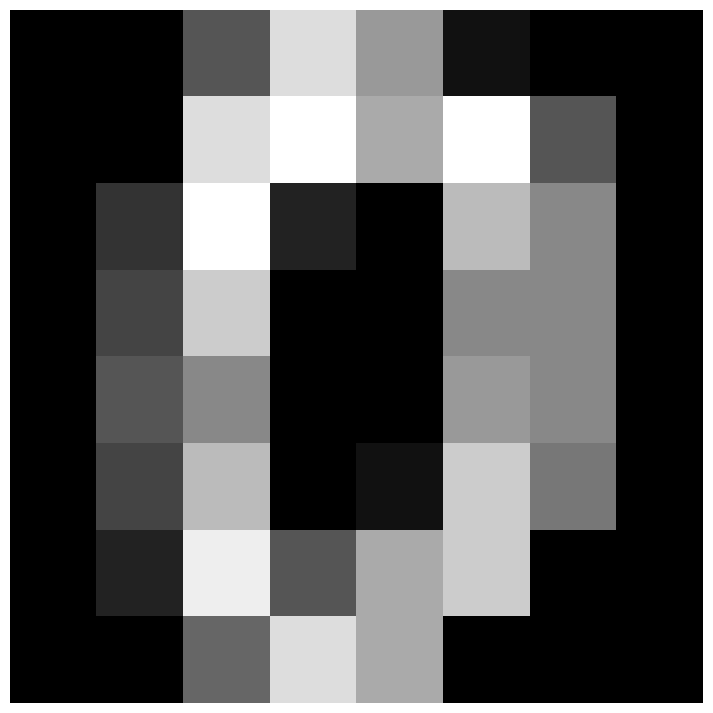

In [68]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [120]:
def algorithm_selection(X, y=[], n_clusters=2, 
                        distances=["euclidean", "manhattan", "cosine", 'minkowski'], 
                        algorithms=['average', 'single', 'complete'], 
                        metrics=['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param n_clusters: количество предлагаемых классов
        :param y: метки классов объектов (n_samples)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    distance = []
    linkage = []
    homogenity = []
    completeness = []
    v_measure = []
    silhouette = []
    
    for algorithm in algorithms:
        for curr_dist in distances:
            distance.append(curr_dist)
            linkage.append(algorithm)
            
            ac = AgglomerativeClustering(n_clusters=n_clusters, metric=curr_dist, linkage=algorithm)
            y_pred = ac.fit_predict(X)
            silhouette.append(silhouette_score(X=X, labels=y_pred, metric=curr_dist))
            if len(y) != 0:
                completeness.append(completeness_score(labels_true=y, labels_pred=y_pred))
                homogenity.append(homogeneity_score(labels_true=y, labels_pred=y_pred))
                v_measure.append(v_measure_score(labels_true=y, labels_pred=y_pred))
            
    compare_dataframe = pd.DataFrame({
        "distance": pd.Series(distance),
        "linkage": pd.Series(linkage),
        "homogenity": pd.Series(homogenity),
        "completeness": pd.Series(completeness),
        "v_measure": pd.Series(v_measure),
        "silhouette": pd.Series(silhouette)
    })
    
    return compare_dataframe

In [121]:
# Для двух кластеров картина выглядит удручающе. Увеличим их число, посмотрим, что будет.
algorithm_selection(X, y, n_clusters=2)

distance   linkage  homogenity  completeness  v_measure  silhouette
0   euclidean   average    0.000558      0.271853   0.001114    0.111356
1   manhattan   average    0.030062      0.376695   0.055681    0.111486
2      cosine   average    0.000558      0.271853   0.001114    0.248548
3   minkowski   average    0.000558      0.271853   0.001114    0.111356
4   euclidean    single    0.000565      0.275198   0.001128   -0.002273
5   manhattan    single    0.000565      0.275198   0.001128    0.003094
6      cosine    single    0.000565      0.275198   0.001128    0.022960
7   minkowski    single    0.000565      0.275198   0.001128   -0.002273
8   euclidean  complete    0.165209      0.549408   0.254031    0.080896
9   manhattan  complete    0.052011      0.357351   0.090805    0.093063
10     cosine  complete    0.040045      0.349389   0.071854    0.150013
11  minkowski  complete    0.165209      0.549408   0.254031    0.080896

In [122]:
# 3-20 кластеров
for i in range(3,21):
    print(i, "clusters \n", algorithm_selection(X, y, n_clusters=i), "\n\n")

3 clusters 
      distance   linkage  homogenity  completeness  v_measure  silhouette
0   euclidean   average    0.029618      0.368547   0.054830    0.058408
1   manhattan   average    0.227653      0.777376   0.352173    0.110320
2      cosine   average    0.031774      0.384753   0.058701    0.105782
3   minkowski   average    0.029618      0.368547   0.054830    0.058408
4   euclidean    single    0.001131      0.275514   0.002253   -0.078033
5   manhattan    single    0.001131      0.275514   0.002253   -0.068018
6      cosine    single    0.001122      0.273173   0.002234   -0.013594
7   minkowski    single    0.001131      0.275514   0.002253   -0.078033
8   euclidean  complete    0.246565      0.547607   0.340029    0.081858
9   manhattan  complete    0.237832      0.602874   0.341101    0.080282
10     cosine  complete    0.212356      0.549126   0.306272    0.128802
11  minkowski  complete    0.246565      0.547607   0.340029    0.081858 


4 clusters 
      distance   linkag

12 clusters 
      distance   linkage  homogenity  completeness  v_measure  silhouette
0   euclidean   average    0.735059      0.801244   0.766726    0.166384
1   manhattan   average    0.709652      0.813451   0.758014    0.156214
2      cosine   average    0.710221      0.822164   0.762103    0.240431
3   minkowski   average    0.735059      0.801244   0.766726    0.166384
4   euclidean    single    0.006171      0.273386   0.012070   -0.164390
5   manhattan    single    0.006206      0.274942   0.012139   -0.222794
6      cosine    single    0.006169      0.273268   0.012065   -0.295208
7   minkowski    single    0.006171      0.273386   0.012070   -0.164390
8   euclidean  complete    0.667817      0.665671   0.666742    0.132516
9   manhattan  complete    0.690972      0.671586   0.681141    0.158090
10     cosine  complete    0.618163      0.603915   0.610956    0.163028
11  minkowski  complete    0.667817      0.665671   0.666742    0.132516 


13 clusters 
      distance   link

Исходя из числовых данных оптимальным кажется использование алгоритма иерархической кластеризации с n=14, косинусовым расстоянием, с определением расстояния между кластерами по среднему расстоянию всех точек двух кластеров. Метрики алгоритма:

- Homogenity = 0.763016
- Completeness = 0.798947
- V_measure = 0.780568
- Silhouette-score = 0.268677

P.S. Ощущение, что силуэт-скор не очень впечатляющий.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [6]:
fc_data = pd.read_csv("../data/raw_data/flow_c_data.csv", index_col=0)

In [7]:
# Посмотрим на данные
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [8]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [11]:
fc_data.isna().sum()

FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0
dtype: int64

In [12]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

Пропусков в данных нет, они не стандартизованы. Продолжаем анализ.

У нас имеется 10000 клеток с 9 признаками -- 2-мя косвенными характеристиками размера и 7-ю поверхностными маркерами.

Чтобы более удобно обрабатывать столбцы, переименуем колонки c дефисом.

In [25]:
fc_data.rename(columns = {"FSC-A": "FSC_A", "SSC-A": "SSC_A", "HLA-DR": "HLA_DR"}, inplace=True)

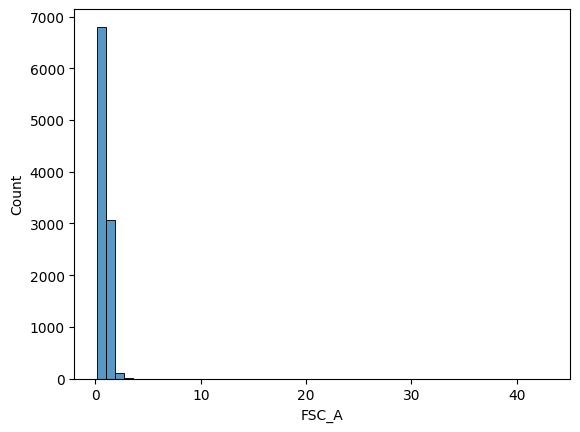

In [27]:
sns.histplot(data=fc_data, x="FSC_A", bins=50);

In [28]:
fc_data.query("FSC_A>10")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   

           CD56      CD19      CD11c  
5843 -12.358701 -9.640775 -11.085437

Обнаружена клетка аномальных размеров. Возможно ошибка измерения.

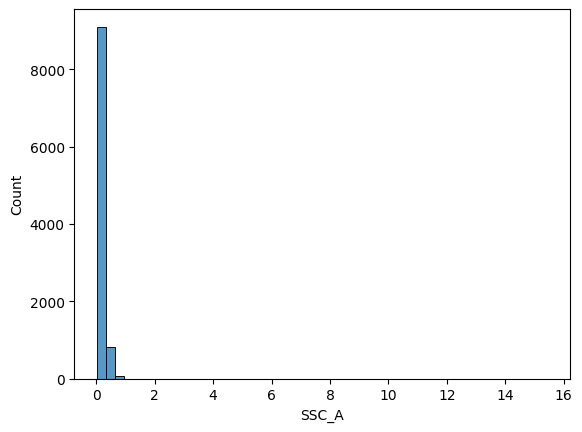

In [30]:
sns.histplot(data=fc_data, x="SSC_A", bins=50);

In [31]:
fc_data.query("SSC_A>2")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   

           CD56      CD19      CD11c  
5843 -12.358701 -9.640775 -11.085437

Однако и второе измерение размера подтверждает аномальные размеры клетки.

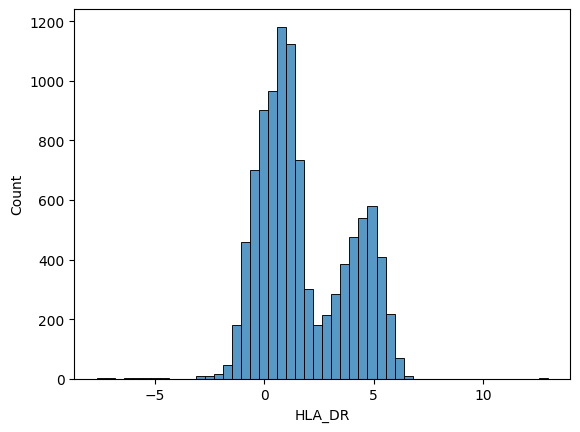

In [33]:
sns.histplot(data=fc_data, x="HLA_DR", bins=50);

In [35]:
fc_data.query("HLA_DR>7 or HLA_DR<-4")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
699    1.922709   0.254377  -4.921411   8.847605   5.307502  1.571615   
1254   1.837845   0.325664  -4.467154   8.703911   6.138194  2.069065   
1505   1.598177   0.335609  -5.232391   9.016271   5.619268  2.253614   
1590   4.092169   0.657198  -7.634172  10.452256  -8.329666  3.199919   
1767   2.667779   0.507324  -6.046983   9.482278  -6.055190  2.200656   
1884   2.178018   0.239796  -5.911095   9.337276  -6.186435  1.975513   
3918   2.600903   0.552938  -5.790973   9.213162  -5.326229  1.876560   
4138   0.957102   0.131970  -4.380748   8.687362   4.751206  0.822527   
5352   3.131965   0.470987  -5.772591   9.374428  -5.097903  2.391261   
5526   1.520960   0.309858  -5.458917   9.177510  -4.156778  1.853277   
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   
6488   2.202049   0.356282  -5.799322   9.256607   3.406094  1.942709   
6646   2.401404   0.363717  -5.350470   9.045771   5.547887  1.488517   
9879   1.412583   0.220539  -6.847628  10.422402   7.612352  2.016084   

           CD56      CD19      CD11c  
699   -0.494133  2.414185   2.736853  
1254  -0.188427  2.289622   4.066358  
1505  -1.210020  3.196415   3.856270  
1590  -3.079160  5.233442  -4.670057  
1767  -1.664012  3.808203   3.141091  
1884  -1.614532  3.496127   3.616438  
3918  -1.172034  3.439671   3.192194  
4138  -0.562957  1.868994   3.710013  
5352  -1.162506  3.418326   4.034943  
5526   3.755729  2.979899   4.396361  
5843 -12.358701 -9.640775 -11.085437  
6488  -1.626368  3.563598   4.060589  
6646  -0.983515  2.837839   3.540914  
9879  -2.211738  4.484005   4.563891

Характерное бимодальное распределение позволяет предположить, что по экспрессии данного компонента главного комплекса гистосовместимости клетки делятся на два кластера. По-прежнему наблюдаем нашу клетку-маргинала -- объект 5843.

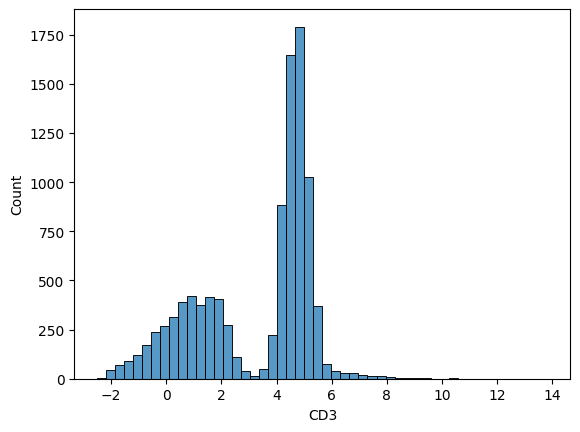

In [36]:
sns.histplot(data=fc_data, x="CD3", bins=50);

In [41]:
fc_data.query("CD3>8.5")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
699    1.922709   0.254377  -4.921411   8.847605   5.307502  1.571615   
1254   1.837845   0.325664  -4.467154   8.703911   6.138194  2.069065   
1505   1.598177   0.335609  -5.232391   9.016271   5.619268  2.253614   
1590   4.092169   0.657198  -7.634172  10.452256  -8.329666  3.199919   
1767   2.667779   0.507324  -6.046983   9.482278  -6.055190  2.200656   
1884   2.178018   0.239796  -5.911095   9.337276  -6.186435  1.975513   
3918   2.600903   0.552938  -5.790973   9.213162  -5.326229  1.876560   
4138   0.957102   0.131970  -4.380748   8.687362   4.751206  0.822527   
5352   3.131965   0.470987  -5.772591   9.374428  -5.097903  2.391261   
5526   1.520960   0.309858  -5.458917   9.177510  -4.156778  1.853277   
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   
6488   2.202049   0.356282  -5.799322   9.256607   3.406094  1.942709   
6646   2.401404   0.363717  -5.350470   9.045771   5.547887  1.488517   
9879   1.412583   0.220539  -6.847628  10.422402   7.612352  2.016084   

           CD56      CD19      CD11c  
699   -0.494133  2.414185   2.736853  
1254  -0.188427  2.289622   4.066358  
1505  -1.210020  3.196415   3.856270  
1590  -3.079160  5.233442  -4.670057  
1767  -1.664012  3.808203   3.141091  
1884  -1.614532  3.496127   3.616438  
3918  -1.172034  3.439671   3.192194  
4138  -0.562957  1.868994   3.710013  
5352  -1.162506  3.418326   4.034943  
5526   3.755729  2.979899   4.396361  
5843 -12.358701 -9.640775 -11.085437  
6488  -1.626368  3.563598   4.060589  
6646  -0.983515  2.837839   3.540914  
9879  -2.211738  4.484005   4.563891

Клетки с маргинальными значениями HLA-DR во многом повторяют клетки с повышенной экспрессией CD3.

В контексте же распределения собственно антигена CD-3 вновь наблюдаем два кластера, причем разных по вариабельности внутри группы.

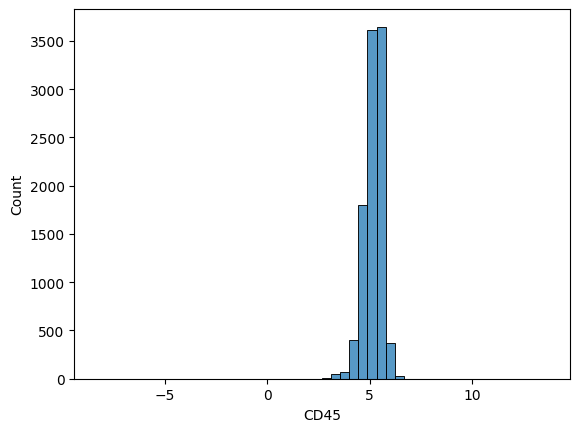

In [38]:
sns.histplot(data=fc_data, x="CD45", bins=50);

In [40]:
fc_data.query("CD45<2 or CD45>7")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
1590   4.092169   0.657198  -7.634172  10.452256  -8.329666  3.199919   
1767   2.667779   0.507324  -6.046983   9.482278  -6.055190  2.200656   
1884   2.178018   0.239796  -5.911095   9.337276  -6.186435  1.975513   
3918   2.600903   0.552938  -5.790973   9.213162  -5.326229  1.876560   
4083   0.292997   0.026985   1.819872   6.583251   1.070088  1.522750   
5352   3.131965   0.470987  -5.772591   9.374428  -5.097903  2.391261   
5526   1.520960   0.309858  -5.458917   9.177510  -4.156778  1.853277   
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   
9879   1.412583   0.220539  -6.847628  10.422402   7.612352  2.016084   

           CD56      CD19      CD11c  
1590  -3.079160  5.233442  -4.670057  
1767  -1.664012  3.808203   3.141091  
1884  -1.614532  3.496127   3.616438  
3918  -1.172034  3.439671   3.192194  
4083   0.051652 -0.475442   1.424817  
5352  -1.162506  3.418326   4.034943  
5526   3.755729  2.979899   4.396361  
5843 -12.358701 -9.640775 -11.085437  
9879  -2.211738  4.484005   4.563891

Унимодальное распределение. Выбросы из числа ранее замеченных клеток.

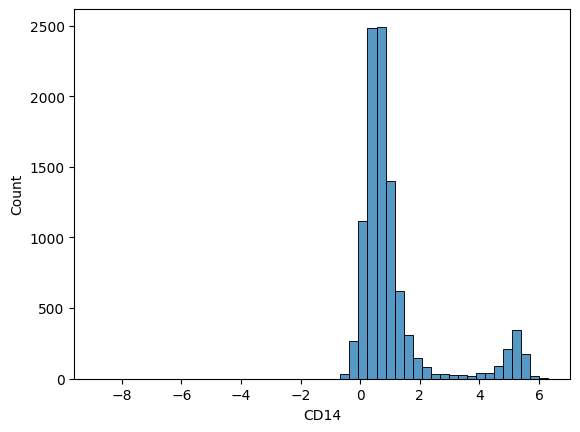

In [43]:
sns.histplot(data=fc_data, x="CD14", bins=50);

In [44]:
fc_data.query("CD14<-1")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   

           CD56      CD19      CD11c  
5843 -12.358701 -9.640775 -11.085437

Два неравнозначных по размеру кластера, 1 выброс (5843).

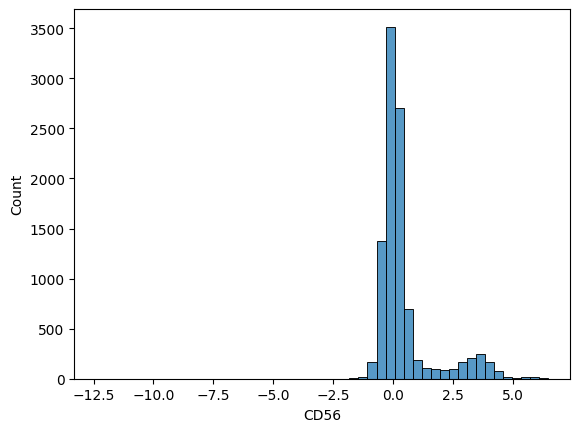

In [45]:
sns.histplot(data=fc_data, x="CD56", bins=50);

In [46]:
fc_data.query("CD56>5 or CD56<-2.5")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
213    0.779066   0.113484  -0.943456   0.978945   4.040249  0.327380   
399    0.858533   0.205605  -0.060731   0.150945   3.315294  0.080718   
533    0.877129   0.162771  -0.828757  -0.966176   3.458635  0.666686   
700    1.000084   0.146514  -0.919814  -0.482957   3.200214  0.038872   
1031   0.669230   0.152131   1.831575  -1.666824   3.742922  0.627892   
1038   1.034639   0.153905  -0.352948   0.732356   3.979104  0.729884   
1093   0.724404   0.153244   0.172882   1.354823   4.063174  0.738478   
1226   1.014039   0.100936   1.268661  -0.373773   4.238311  0.515341   
1234   1.039231   0.111295   0.467990   0.304158   3.651296  1.035917   
1373   0.654149   0.192596   1.335152  -1.047927   4.208797  0.765527   
1449   0.767996   0.125038  -0.414597  -0.163043   3.362898  0.011131   
1545   1.008883   0.232897  -0.010770  -0.880924   3.888246  0.677209   
1590   4.092169   0.657198  -7.634172  10.452256  -8.329666  3.199919   
2189   0.810320   0.164711   1.491916  -0.756140   4.398341  0.541775   
2271   0.857443   0.151022  -0.783061  -0.797848   4.261624  0.853118   
2316   0.814233   0.264768  -0.133076  -0.286083   3.868843  0.486861   
2578   0.885792   0.123159  -0.955915   0.271544   2.971744  0.238914   
2873   0.762579   0.150032  -0.101292  -0.651165   4.418173  0.667014   
3167   0.881486   0.166703   0.568116  -1.092351   3.618078  2.154012   
3355   0.838940   0.094497   1.515049  -0.116451   3.785500  0.539602   
4191   0.587134   0.194699   0.376056   0.717837   3.482689  1.807675   
4194   1.092966   0.122449   0.363867  -1.364519   3.432339  0.435680   
4279   0.906127   0.229117   0.695487  -0.432117   4.380269  0.884613   
4403   0.951452   0.174056   0.720992   0.416477   3.623710  0.449062   
4757   0.695906   0.136789  -0.495652  -0.841754   3.936842  0.322638   
5014   0.613868   0.164262   0.694422  -0.221893   3.437320  0.763037   
5282   0.651201   0.168744  -0.270523   0.358503   4.560015  0.302310   
5283   0.776904   0.135080   0.012885  -0.641240   3.159664  0.597481   
5358   0.686519   0.133061   0.159082  -1.060934   4.994628 -0.061453   
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   
6011   0.548176   0.193300  -0.931930   0.146698   3.747802  1.080979   
7298   0.899883   0.156634  -1.311318  -0.992248   3.567530  0.466414   
7607   0.776480   0.147699  -0.337111  -0.126577   3.771214  0.384860   
8035   0.814895   0.113618   5.931423   2.197866   5.094075  0.753374   
8436   0.769481   0.148489  -0.744465  -0.546188   3.589892  0.141550   
8487   1.085472   0.145177   0.107223   0.833622   3.924708  0.724104   
8493   0.712811   0.168916   4.609472  -1.093936   5.437417  1.200768   
8593   0.939913   0.180972   0.144940  -0.324550   4.111105  0.908136   
8634   0.913143   0.207735   1.426593   0.225537   4.766563  0.806280   
8674   0.883104   0.132731  -2.208636  -1.299707   3.451875  0.506331   
9163   0.551244   0.145866   0.647675  -0.416353   4.896949  0.502987   
9764   0.837456   0.144033   0.793506  -1.539560   3.650018  0.730048   

           CD56      CD19      CD11c  
213    5.388754 -1.317169   2.113790  
399    6.461899 -2.108680   1.311429  
533    5.315234 -0.900211   0.274179  
700    5.892648 -2.109247  -0.600564  
1031   5.680513 -1.295483   0.637012  
1038   6.170781 -2.315996   0.795248  
1093   6.099695 -0.497390   0.777710  
1226   5.768695  1.541684  -0.598371  
1234   5.293680  1.171054   1.786675  
1373   5.778567 -1.354192   2.506573  
1449   5.711007  0.108841   0.092845  
1545   5.836103 -2.006241   0.601203  
1590  -3.079160  5.233442  -4.670057  
2189   5.819013 -2.201499   1.548926  
2271   6.130979  0.626452   1.379831  
2316   5.554159 -1.363083   0.766884  
2578   5.585114 -0.582360   0.802130  
2873   5.536200 -0.807822   1.485532  
3167   5.504304  1.430176  -0.093124  
3355   5.388627 -1.620428  -0.287091  
4191   6.234129 -1.278484   0.092973  
4194   6.007

Тенденция к наличию двух кластеров. Один резко отрицательный выброс (5843) и большая подгруппа резко положительных.

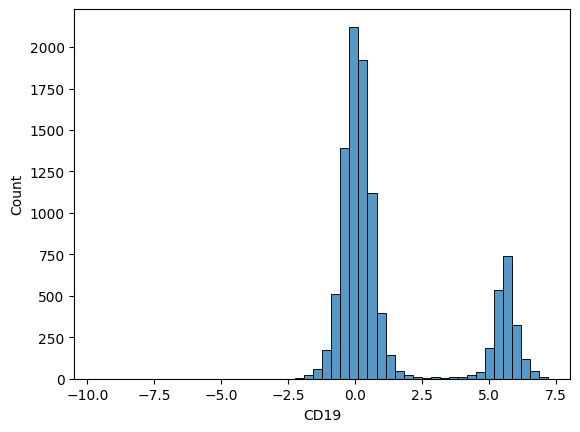

In [47]:
sns.histplot(data=fc_data, x="CD19", bins=50);

In [49]:
fc_data.query("CD19<-2.5")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   
6011   0.548176   0.193300  -0.931930   0.146698   3.747802  1.080979   

           CD56      CD19      CD11c  
5843 -12.358701 -9.640775 -11.085437  
6011   5.926532 -2.639452   1.206850

2 кластера, 2 отрицательных выброса, 2 строчки кода до конца части с распределениями.

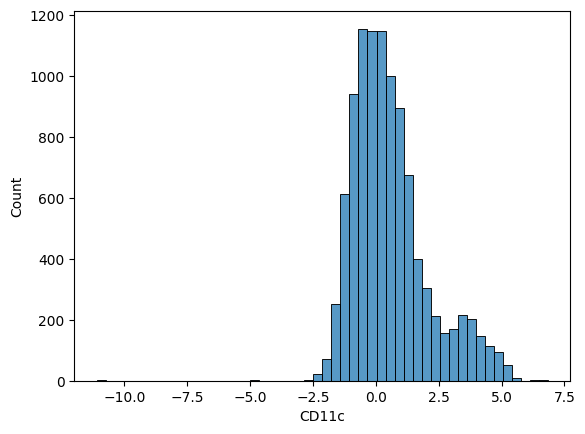

In [50]:
sns.histplot(data=fc_data, x="CD11c", bins=50);

In [51]:
fc_data.query("CD11c>5.25 or CD11c<-3")

FSC_A      SSC_A     HLA_DR        CD3       CD45      CD14  \
464    0.744304   0.367309   4.812515   1.893431   4.505462  4.866881   
583    0.957787   0.079172   5.337771   1.173369   4.784616  0.270023   
623    0.762808   0.124565   5.184695  -2.269957   4.867764  1.006512   
1328   0.890819   0.349926   3.623548   2.461673   5.028399  4.632246   
1547   1.194691   0.414504   4.641983   1.629092   5.492470  5.178760   
1590   4.092169   0.657198  -7.634172  10.452256  -8.329666  3.199919   
1991   1.587543   0.247678   4.759989   1.946962   5.714572  4.047044   
3563   0.776808   0.131416   4.442723  -0.304477   4.734086  0.389769   
4450   1.336206   0.453728   5.473127   2.465605   5.181812  5.413311   
5511   1.430116   0.315915   5.129777   0.407764   5.870166  4.969340   
5843  42.954485  15.460997  12.946668  13.844391  13.710922 -8.833883   
6060   1.249581   0.225944   6.172918  -0.008377   5.223570  1.088006   
6067   1.099471   0.333541   5.622112   2.007120   5.439783  5.042792   
6154   1.215504   0.354954   3.954474   2.725061   5.306304  4.614058   
6503   0.943408   0.201611   4.441851  -1.007447   5.377238  2.074747   
6666   1.334098   0.231278   5.531720   2.264655   4.860497  1.411596   
8208   1.422075   0.345450   3.767413   1.296864   5.528081  4.398942   
8379   0.911888   0.304431   5.110700  -1.138213   5.926456  5.214502   
8633   1.055465   0.326212   4.768902   2.259602   5.602586  4.247809   
9407   1.240245   0.538537   4.263834   1.434613   5.739408  4.307187   

           CD56      CD19      CD11c  
464   -0.282111 -0.375701   5.621544  
583    0.847127  5.601301   5.499565  
623    0.090351  4.979957   6.213018  
1328   1.111648  0.235170   5.512574  
1547  -0.011368 -0.378478   5.467070  
1590  -3.079160  5.233442  -4.670057  
1991   0.455064 -0.131509   5.473361  
3563   0.152073  5.862007   6.840864  
4450   0.432358  0.314993   5.606509  
5511   0.010491 -1.812131   5.691194  
5843 -12.358701 -9.640775 -11.085437  
6060   2.112224 -1.285892   5.262563  
6067  -0.479491 -1.762455   5.408245  
6154   0.807644  0.721523   5.395735  
6503   0.708323 -0.393902   5.295569  
6666  -0.798583 -0.221779   5.367522  
8208  -0.392093  0.452438   5.327853  
8379   0.275816 -1.607350   5.668427  
8633  -0.517542 -0.095618   5.253138  
9407   0.251724  1.051646   5.506176

Здест граница между потенциальными кластерами обозначена не так резко, но может предполагаться. Два резко отрицательных выброса, группа положительных.

Клетка номер 5843 выглядит аномальной. Сложно предположить, что на 10000 клеток нашлась одна с настолько ярко выраженными изменениями размера и экспрессии маркеров. Для большей валидности дальнейшего анализа решено ее исключить из датасета.

In [52]:
fc_data = fc_data.query("CD14>-1")

Стандартизируем данные.

In [71]:
from sklearn.preprocessing import StandardScaler

colnames = fc_data.columns
sc = StandardScaler()
fc_data_st = pd.DataFrame(dict(zip(colnames, fc_data_st.T)))
fc_data_st.describe()

FSC_A         SSC_A        HLA_DR           CD3          CD45  \
count  9.999000e+03  9.999000e+03  9.999000e+03  9.999000e+03  9.999000e+03   
mean   7.035077e-17  2.211785e-16  1.016178e-16  7.745690e-17  1.266314e-15   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -2.997606e+00 -1.247696e+00 -4.655960e+00 -2.748117e+00 -2.640797e+01   
25%   -5.876812e-01 -5.117469e-01 -7.486654e-01 -8.900152e-01 -4.827697e-01   
50%   -1.831587e-01 -2.926277e-01 -2.948152e-01  5.187007e-01  1.272301e-01   
75%    3.452802e-01 -1.192052e-02  9.415984e-01  7.408890e-01  6.107238e-01   
max    1.181502e+01  8.080503e+00  2.415026e+00  3.400400e+00  4.780046e+00   

               CD14          CD56          CD19         CD11c  
count  9.999000e+03  9.999000e+03  9.999000e+03  9.999000e+03  
mean   7.905578e-17  6.821892e-17 -2.611506e-17 -2.229551e-17  
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  
min   -1.269110e+00 -2.985139e+00 -1.691060e+00 -3.498941e+00  
25%   -5.162294e-01 -5.208610e-01 -5.991020e-01 -7.141378e-01  
50%   -3.098515e-01 -3.078631e-01 -4.278171e-01 -1.993447e-01  
75%   -2.403619e-02 -2.983274e-02 -1.368235e-01  4.336302e-01  
max    3.786425e+00  5.169501e+00  2.623163e+00  4.185681e+00

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [75]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

/tmp/ipykernel_5236/3536361148.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


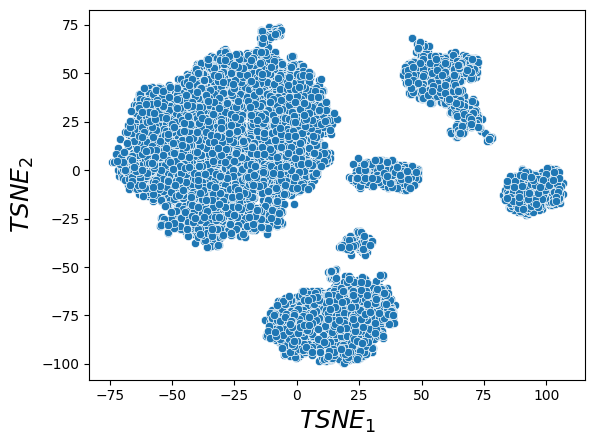

In [83]:
# На стандартизованных данных
tsne_res = plot_tsne(fc_data_st)

/tmp/ipykernel_5236/3536361148.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


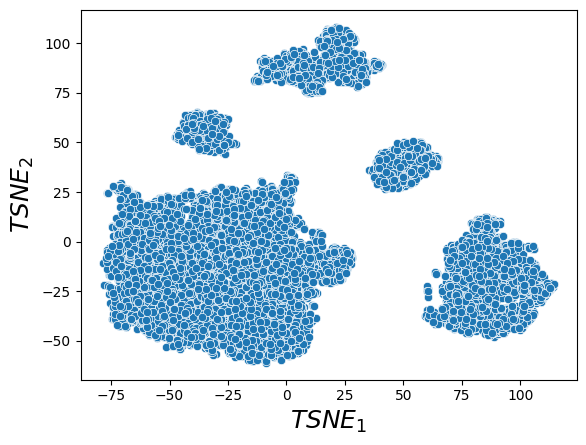

In [84]:
# На нестандратизованных данных
tsne_res2 = plot_tsne(fc_data)

/tmp/ipykernel_5236/3536361148.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


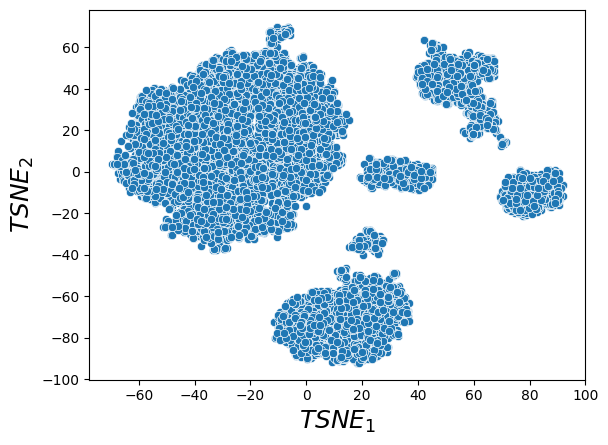

In [77]:
# На стандартизованных данных, другие параметры
tsne_res3 = plot_tsne(fc_data_st, n_iter=2000, perplexity=50)

/tmp/ipykernel_5236/3536361148.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tsne_embedding[:, 0],


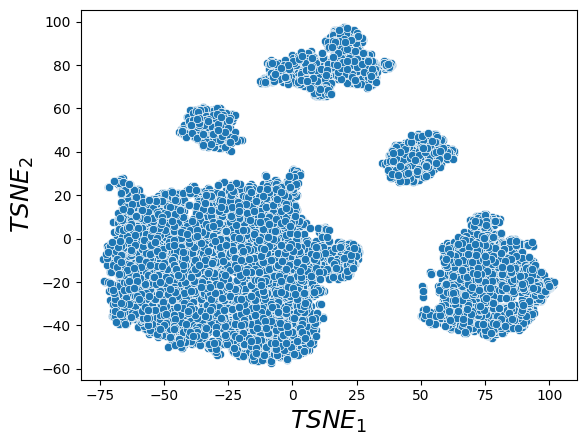

In [78]:
# На нестандратизованных данных, другие параметры
tsne_res4 = plot_tsne(fc_data, n_iter=2000, perplexity=50)

Игрища с параметрами ничего не изменили.

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

У кластера достаточно большая размерность (9), данных много (10000). Поэтому начнем с алгоритма DBSCAN.

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

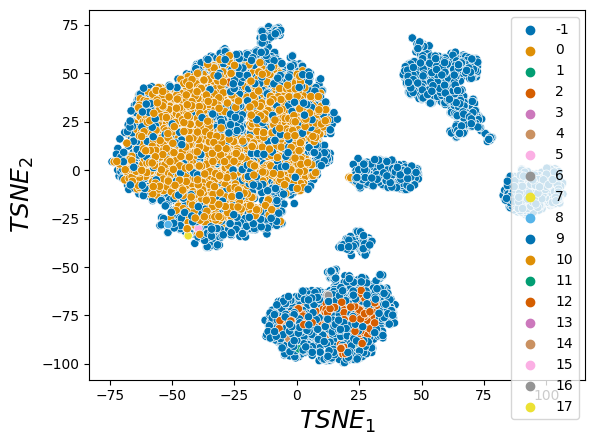

In [91]:
# Запустим с параметрами по умолчанию.
db = DBSCAN()
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Вышло очень дурно. Увеличим eps

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

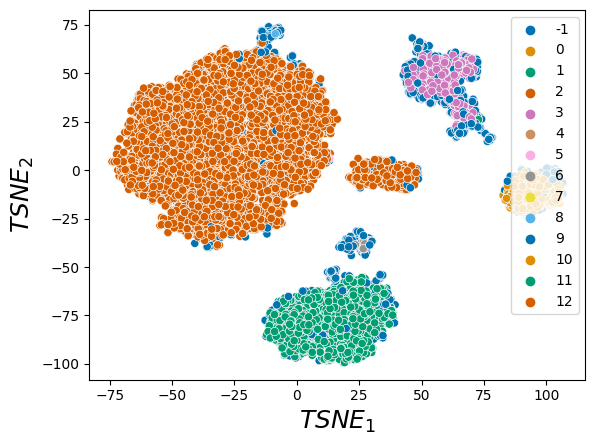

In [92]:
db = DBSCAN(eps=1)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Уже лучше, но все еще ловятся дырки и много клауда. Попробуем уменьшить число необходимых соседей и увеличить eps одновременно

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

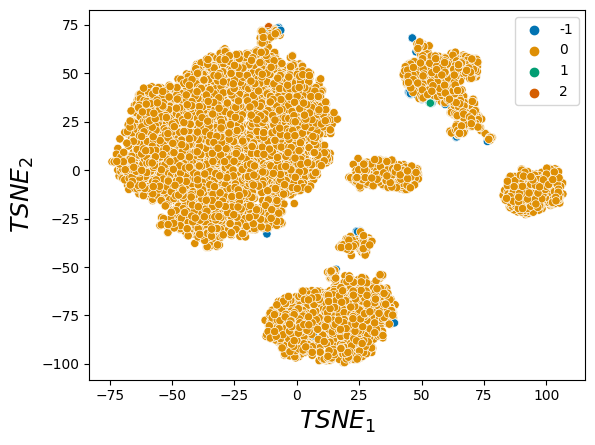

In [94]:
db = DBSCAN(eps=2, min_samples=4)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Случился какой-то мрак. Попробуем откатить назад.

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

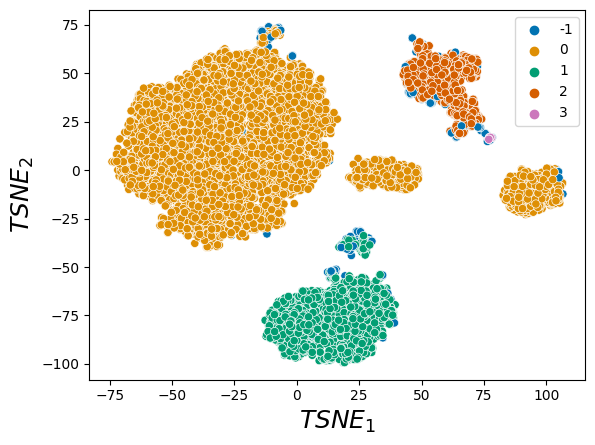

In [95]:
db = DBSCAN(eps=1.5)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Стало чуть лучше. Попробуем поднять eps до двойки, но увеличить min_samples

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

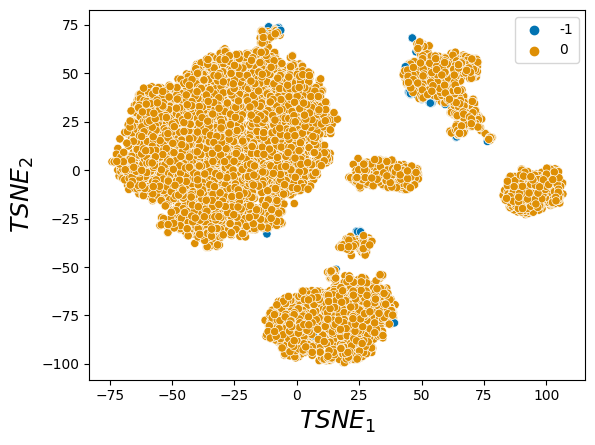

In [96]:
db = DBSCAN(eps=2, min_samples=6)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Опять плохо. Оставляем большой min_samples, уменьшаем eps

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

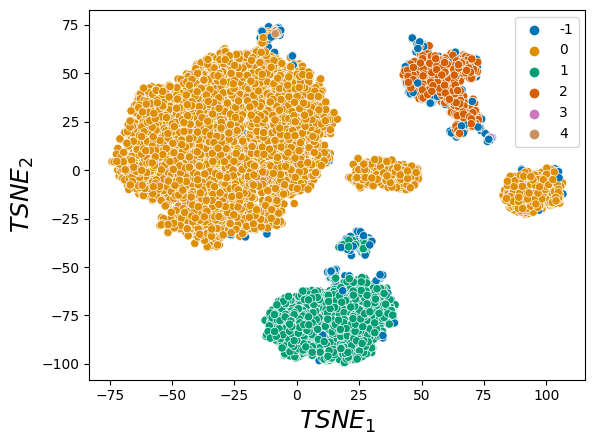

In [97]:
db = DBSCAN(eps=1.3, min_samples=6)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Уменьшим eps и min_samples

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

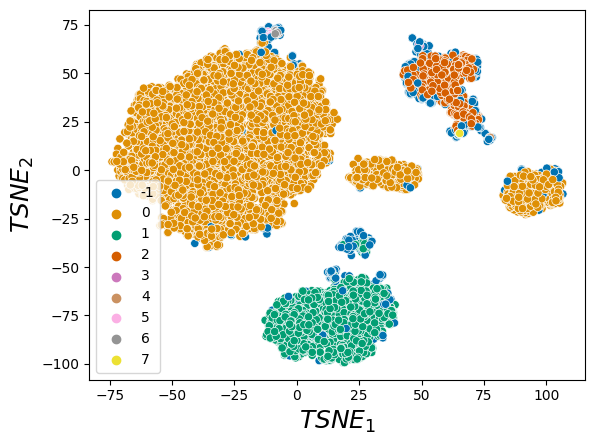

In [98]:
db = DBSCAN(eps=1.1, min_samples=4)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Возвращаем min_samples=5

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

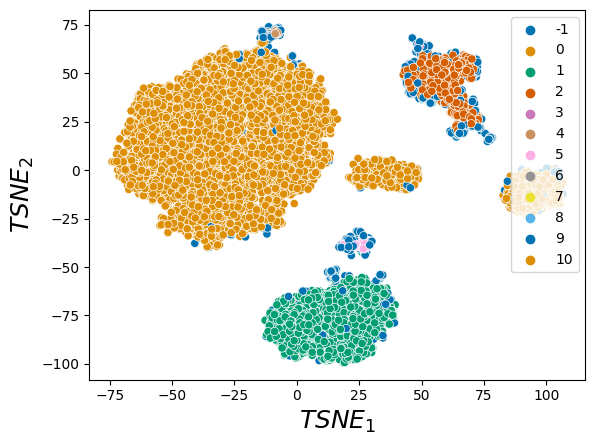

In [99]:
db = DBSCAN(eps=1.1, min_samples=5)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

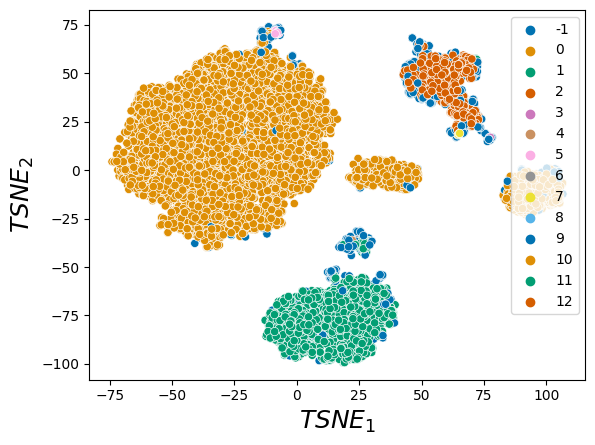

In [100]:
db = DBSCAN(eps=1.1, min_samples=3)
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)

In [ ]:
### Тут было много шагов с Манхэттэном

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

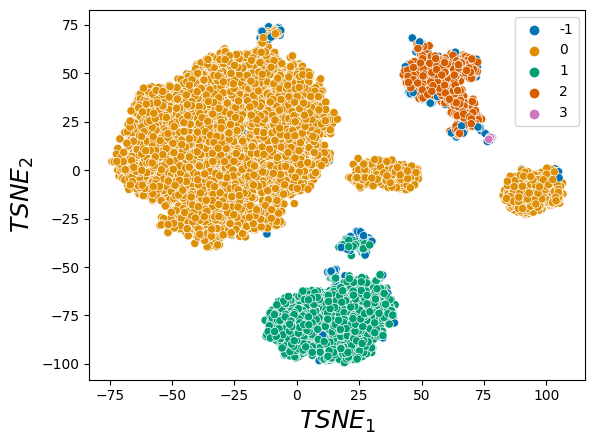

In [107]:
db = DBSCAN(eps=3.5, min_samples=9, metric="manhattan")
db_default_answers = db.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=db_default_answers)
# Где-то здесь я решил запустить функцию из второй части для иерархической кластеризации

In [111]:
for number in range(2, 10):
    print(number, "\n", algorithm_selection(fc_data_st, n_clusters=number), "\n\n")

/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


2 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.843096
1  manhattan   average         NaN           NaN        NaN    0.804086
2     cosine   average         NaN           NaN        NaN    0.533066
3  euclidean    single         NaN           NaN        NaN    0.843096
4  manhattan    single         NaN           NaN        NaN    0.804086
5     cosine    single         NaN           NaN        NaN    0.053379
6  euclidean  complete         NaN           NaN        NaN    0.843096
7  manhattan  complete         NaN           NaN        NaN    0.804086
8     cosine  complete         NaN           NaN        NaN    0.531319 




/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


3 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.833762
1  manhattan   average         NaN           NaN        NaN    0.788863
2     cosine   average         NaN           NaN        NaN    0.543715
3  euclidean    single         NaN           NaN        NaN    0.833762
4  manhattan    single         NaN           NaN        NaN    0.788863
5     cosine    single         NaN           NaN        NaN   -0.211985
6  euclidean  complete         NaN           NaN        NaN    0.411267
7  manhattan  complete         NaN           NaN        NaN    0.524667
8     cosine  complete         NaN           NaN        NaN    0.450960 




/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


4 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.619647
1  manhattan   average         NaN           NaN        NaN    0.619474
2     cosine   average         NaN           NaN        NaN    0.619862
3  euclidean    single         NaN           NaN        NaN    0.809351
4  manhattan    single         NaN           NaN        NaN    0.756877
5     cosine    single         NaN           NaN        NaN   -0.300639
6  euclidean  complete         NaN           NaN        NaN    0.411129
7  manhattan  complete         NaN           NaN        NaN    0.524585
8     cosine  complete         NaN           NaN        NaN    0.370185 




/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


5 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.578083
1  manhattan   average         NaN           NaN        NaN    0.490350
2     cosine   average         NaN           NaN        NaN    0.562350
3  euclidean    single         NaN           NaN        NaN    0.594477
4  manhattan    single         NaN           NaN        NaN    0.619393
5     cosine    single         NaN           NaN        NaN   -0.358608
6  euclidean  complete         NaN           NaN        NaN    0.341479
7  manhattan  complete         NaN           NaN        NaN    0.354501
8     cosine  complete         NaN           NaN        NaN    0.306325 




/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


6 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.550465
1  manhattan   average         NaN           NaN        NaN    0.429149
2     cosine   average         NaN           NaN        NaN    0.486179
3  euclidean    single         NaN           NaN        NaN    0.560711
4  manhattan    single         NaN           NaN        NaN    0.496037
5     cosine    single         NaN           NaN        NaN   -0.389088
6  euclidean  complete         NaN           NaN        NaN    0.323425
7  manhattan  complete         NaN           NaN        NaN    0.354363
8     cosine  complete         NaN           NaN        NaN    0.212981 




/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


7 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.545052
1  manhattan   average         NaN           NaN        NaN    0.501583
2     cosine   average         NaN           NaN        NaN    0.449947
3  euclidean    single         NaN           NaN        NaN    0.546985
4  manhattan    single         NaN           NaN        NaN    0.442460
5     cosine    single         NaN           NaN        NaN   -0.397258
6  euclidean  complete         NaN           NaN        NaN    0.321508
7  manhattan  complete         NaN           NaN        NaN    0.353811
8     cosine  complete         NaN           NaN        NaN    0.213433 




/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


8 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.542638
1  manhattan   average         NaN           NaN        NaN    0.494633
2     cosine   average         NaN           NaN        NaN    0.438566
3  euclidean    single         NaN           NaN        NaN    0.544859
4  manhattan    single         NaN           NaN        NaN    0.436780
5     cosine    single         NaN           NaN        NaN   -0.404199
6  euclidean  complete         NaN           NaN        NaN    0.312524
7  manhattan  complete         NaN           NaN        NaN    0.361647
8     cosine  complete         NaN           NaN        NaN    0.368749 


9 
     distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average         NaN           NaN        NaN    0.530487
1  manhattan   average         NaN           NaN        NaN    0.494559
2     cosine   average         NaN           NaN     

/tmp/ipykernel_5236/164137616.py:39: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "homogenity": pd.Series(homogenity),
/tmp/ipykernel_5236/164137616.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "completeness": pd.Series(completeness),
/tmp/ipykernel_5236/164137616.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  "v_measure": pd.Series(v_measure),


In [ ]:
Оптимальным решением выглядят 2-4 кластера с учетом минимального межкластерного расстояния и евклидовой дистанции.

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

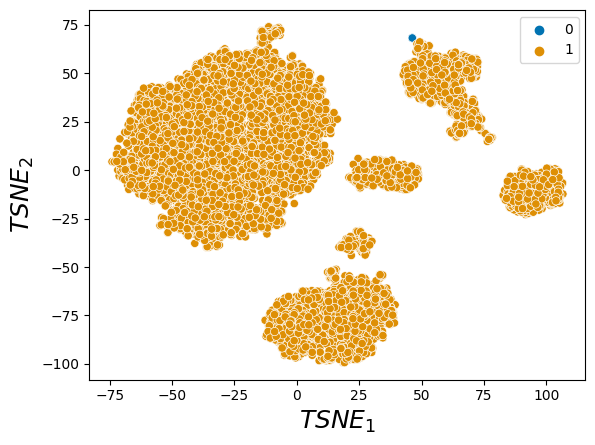

In [123]:
acl = AgglomerativeClustering(n_clusters=2, metric="euclidean", linkage="single")
acl_default_answers = acl.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=acl_default_answers)
# Все грустно. Увеличим число кластеров.

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

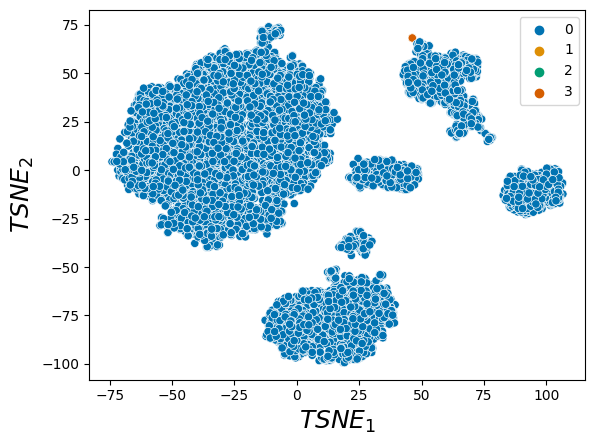

In [124]:
acl = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="single")
acl_default_answers = acl.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=acl_default_answers)
# Поиграем с трешолдом

array([[103.78371714,  -6.4100756 ],
       [ 11.84552138, -78.29777279],
       [-63.91236718,  36.13558579],
       ...,
       [ 69.87549959,  23.95566749],
       [103.8278597 , -15.84348566],
       [ 97.22797738,  -8.63473674]])

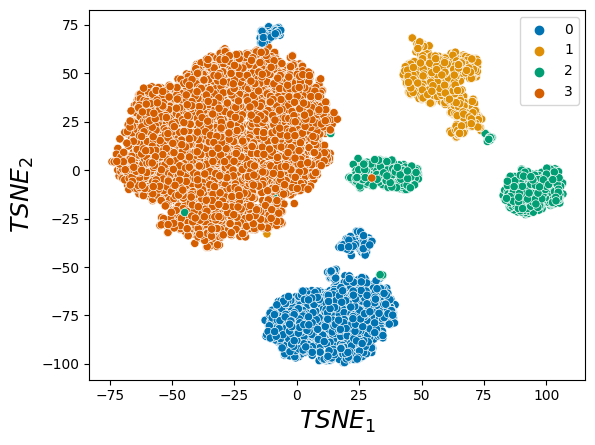

In [134]:
acl = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
acl_default_answers = acl.fit_predict(fc_data_st)
final_plot = plot_tsne(fc_data_st, color=acl_default_answers)
final_plot
# Игры с трэшхолдом закончились ошибкой (надо выбирать или число кластеров, или трэшхолд, заменили ликэдж, как об этом писали в чате)
# Похоже на хороший вариант

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Почти.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

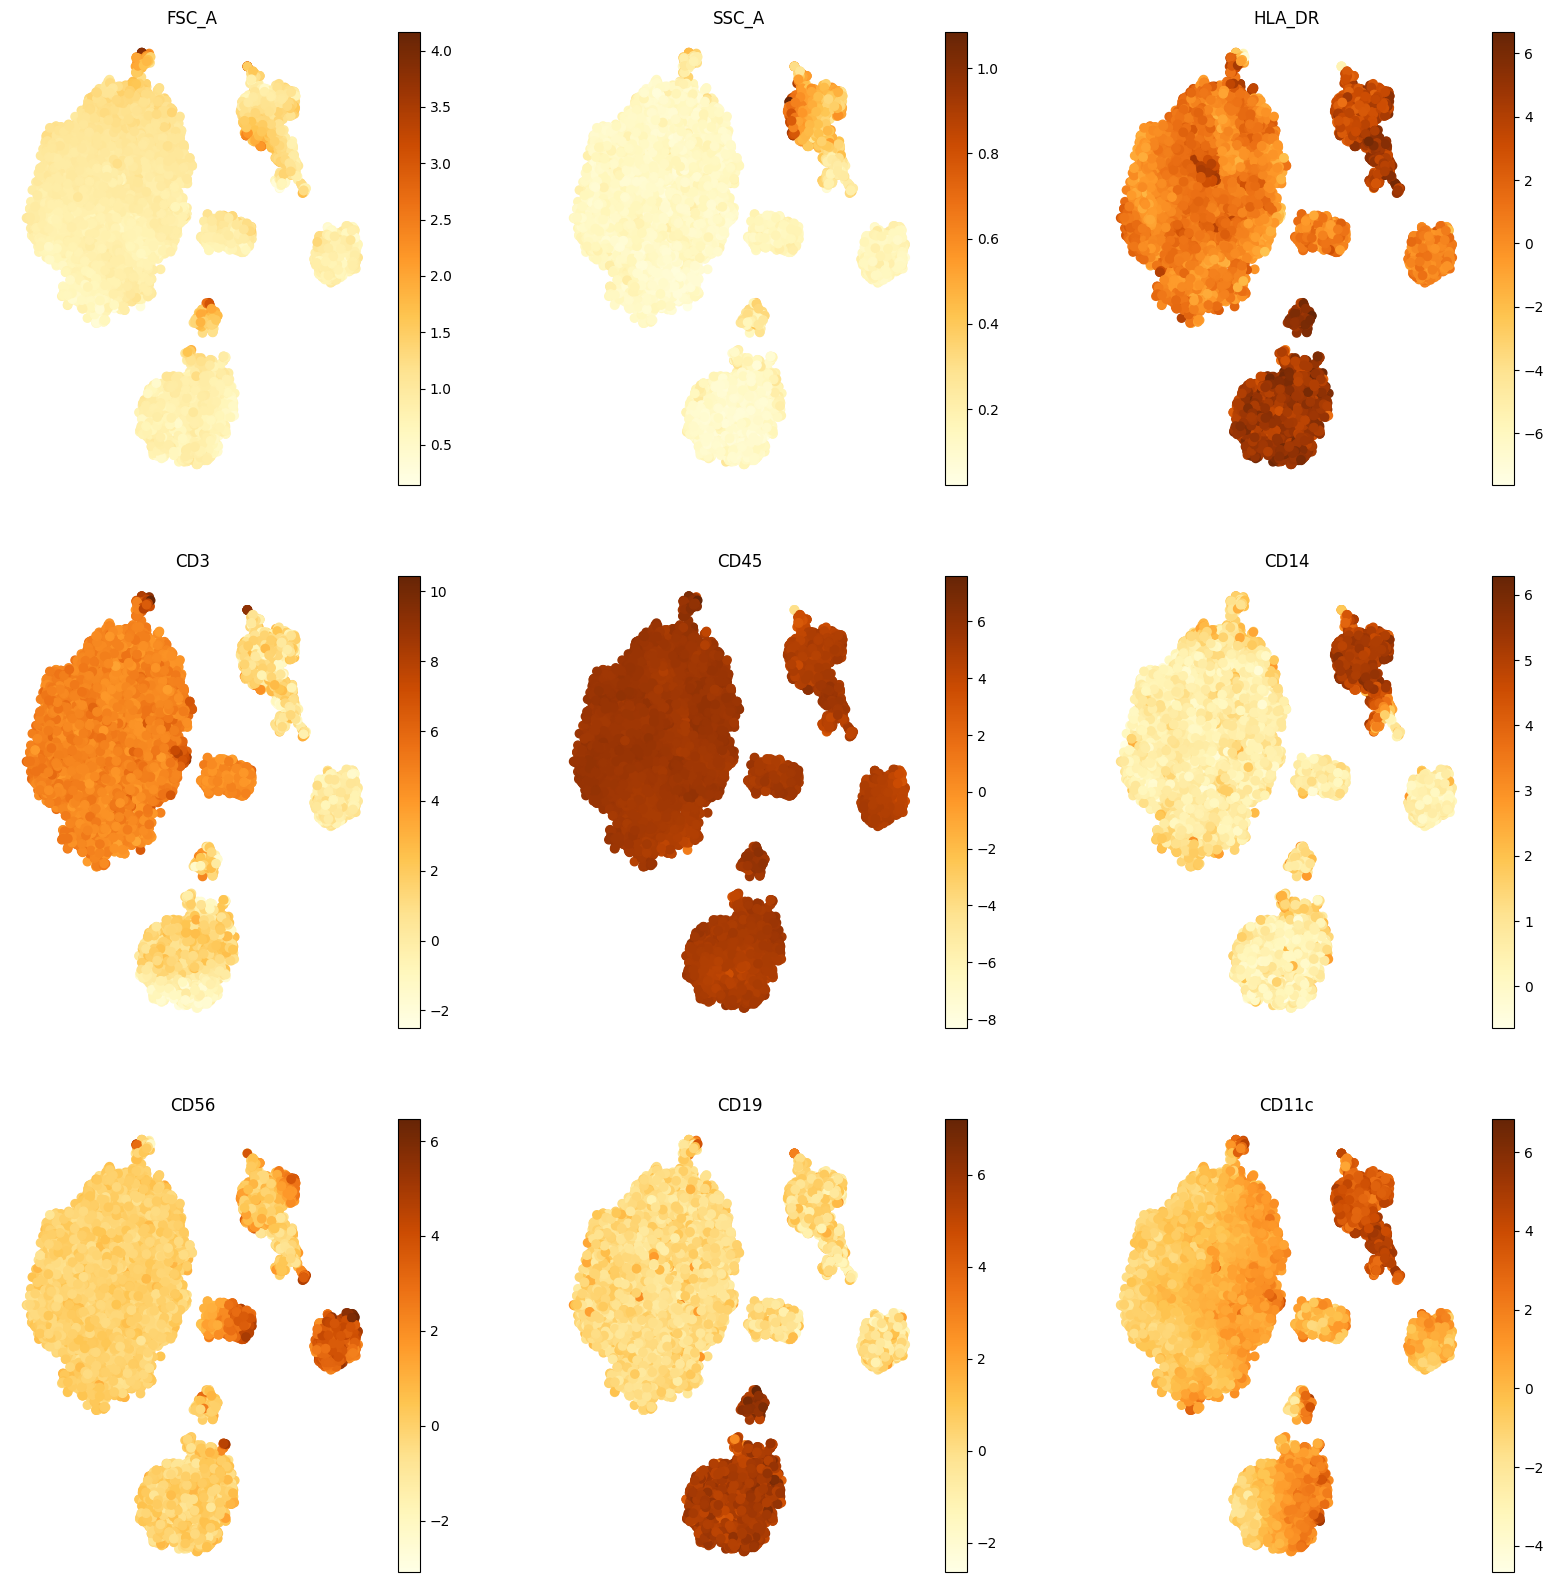

In [129]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [ ]:
- CD19 характерен для B-лимфоцитов
- CD14 преимущественно для моноцитов и макрофагов
- CD3 для T-лимфоцитов

In [130]:
cell_type_cluster_map = {0: "B_cells", 
                         1: "Monocytes", 
                         2: "Other cells", 
                         3: "T_cells"}

In [137]:
labeled_fc_data = fc_data.assign(Population=acl_default_answers)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [139]:
labeled_fc_data["Population"].value_counts()

T_cells        5657
B_cells        2126
Other cells    1135
Monocytes      1081
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [143]:
labeled_fc_data.to_csv("../data/processed_data/labeled_fc_data.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

In [147]:
labeled_fc_data.describe()

FSC_A        SSC_A       HLA_DR          CD3         CD45  \
count  9999.000000  9999.000000  9999.000000  9999.000000  9999.000000   
mean      0.958259     0.163885     1.790463     3.279335     5.168991   
std       0.271388     0.113998     2.024310     2.109540     0.511184   
min       0.144786     0.021657    -7.634172    -2.517639    -8.329666   
25%       0.798777     0.105550     0.275008     1.401906     4.922219   
50%       0.908554     0.130528     1.193696     4.373500     5.234026   
75%       1.051959     0.162526     3.696455     4.842191     5.481168   
max       4.164550     1.085003     6.678981    10.452256     7.612352   

              CD14         CD56         CD19        CD11c  
count  9999.000000  9999.000000  9999.000000  9999.000000  
mean      1.098176     0.413500     1.220769     0.571064  
std       1.372355     1.170075     2.282836     1.497991  
min      -0.643408    -3.079160    -2.639452    -4.670057  
25%       0.389761    -0.195916    -0.146814    -0.498655  
50%       0.672971     0.053295     0.244182     0.272462  
75%       1.065191     0.378595     0.908439     1.220606  
max       6.294236     6.461899     7.208721     6.840864

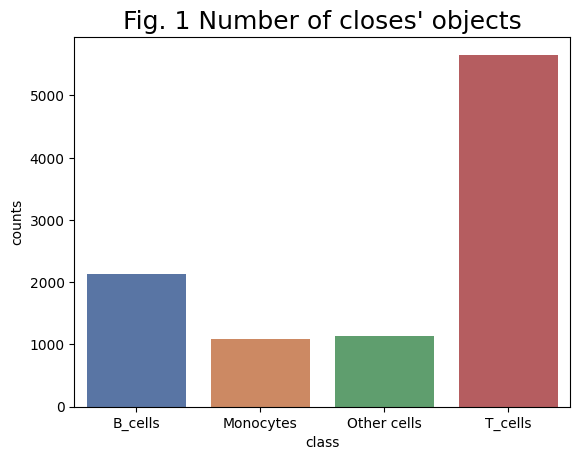

In [166]:
unique, counts = np.unique(y, return_counts=True)
class_freq = pd.DataFrame({
    "class": unique,
    "counts": counts,
})
axes = sns.barplot(class_freq, x="class", y="counts", palette=("deep")).set_title("Fig. 1 Number of closes' objects", fontsize=18)
axes;

Отметим определенный дисбаланс классов.

In [181]:
X, y = labeled_fc_data.loc[:, labeled_fc_data.columns != "Population"], labeled_fc_data.loc[:, "Population"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [183]:
# Создаем пайплайн
# 8 пока так и тянется сакральным числом из первой домашки
class_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=8))
])

In [185]:
class_pipeline.fit(X_train, y_train)
y_pred = class_pipeline.predict(X_test)

In [188]:
f1_score(y_test, y_pred, average="macro")

0.998604865252387

Мне нравится этот f1! Я подумывал насчет того, чтобы добавить веса через ```weights``` в  KNeighborsClassifier, но, пожалуй, оставлю и этот вариант. Он выглядит очень недурно.

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Не бывал, не буду весной, но хотел бы когда-нибудь побывать в исторических частях испанских городов, в частности ассоциированных с событиями 16-17 веков: Толедо, Мадрид, Вальядолид, Кордова, Кадис, Севилья и так далее.

Прикладываю фото Толедо из сети:![фото Толедо из сети](https://kuku.travel/wp-content/uploads/2020/01/%D0%BE%D0%B1%D0%BB%D0%BE%D0%B6%D0%BA%D0%B0.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Как выяснилось, когда модели визуализируются, подбирать их веселее.

Кажется, что было чуть попроще (пока я не знаю итогов), но за 3 часа пока сделать сие не выходит. 

Понравилось, что было больше биологических данных в этот раз.